# Телеком: прогноз оттока клиентов

**Описание** **задачи**:

Оператор связи хочет прогнозировать оттток клиентов. В отношении абонентов, которые намерены уйти, будут применяться меры для их удержания (предложение скидок и другие). На основе данных необходимо найти решение, позволяющее решить поставленную задачу.

В распоряжении имеются данные о части клиентов оператора связи, они содержатся в нескольких датафреймах:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.


Таким образом моей целью является создание модели, которая будет основе данных о клиентах выполнять задачу бинарной классификации: уйдет клиент или нет (целевым признаком в данных является признак EndDate). Оценивать модель буду с помощью метрики ROC-AUC, минимально удовлетворительным будет считаться показатель ROC-AUC > 0.75, но желательно добиться показателя ROC-AUC ≥ 0.88. 

Для того, чтобы добиться приемлемого качества модели, нужно подготовить данные и исследовать их. На начальном этапе определю для себя несколько задач и отражу их в плане выполнения работы. По ходу работы будут появляться и другие задачи, требующие решения.


## План работы:

1. Обзор данных
2. Преобработка данных
  - Провести проверку на наличие пропусков и дубликатов, изменить неправильные типы данных
  - Привести к удобному типу для дальнейшей работы (например, 'yes' и 'no' можно преобразовать в 0 и 1.
  - Возможно следует объединить имеющиеся таблицы.
3. EDA
  - Изучить аномалии .
  - Посмотреть, как распределен целевой признак, предварительно можно выделить его в отдельный признак.
  - Построить графики, решить, как выполнить: либо составить портрет типичного ушедшего пользователя и сравнивать с типичным остающимся абонентом, либо анализировать именно признаки, насколько каждый из них влияет на уход абонента.
  - Построить pairplot признаков, сделать заливку по целевому признаку.
  - Посмотреть на корреляцию между самими признаками.
4. Подготовка признаков для обучения
  - Можно создать дополнительные признаки, но не допустить утечку целевого признака.
  - Провести OHE и стандартизацию.
  - Разделить данные на выборки.
  - Сделать dummy модель, чтобы оценить модель на адекватность.
5. Обучение моделей
  - Взять простую модель, модели градиентного бустинга.
  - Сделать перебор гиперпараметров.
6. Выводы
  - Оценить полученные метрики и сравнить.
  - Посмотреть, какие признаки имели наибольшее значение.
  - Достаточно ли точности модели для выявления компанией клиентов, которые намереваются уйти.

## Обзор данных

### Импорт инструментов

Импортирую необходимые библиотеки выполнения работы

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 5.1 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import notebook
import warnings

from catboost import CatBoostClassifier, cv, Pool

import lightgbm as lgb

from imblearn.over_sampling import SMOTE 

import phik
from phik.report import plot_correlation_matrix
from phik import report

from scipy import stats as st

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

In [ ]:
pd.set_option('display.max_columns', 30)

### Обзор данных и предобработка

Открою файлы с данными и проведу предварительный обзор

In [ ]:
personal1 = '/personal.csv'
personal2 = '/datasets/final_provider/personal.csv'

contract1 = '/contract.csv'
contract2 = '/datasets/final_provider/contract.csv'

internet1 = '/internet.csv'
internet2 = '/datasets/final_provider/internet.csv'

phone1 = '/phone.csv'
phone2 = '/datasets/final_provider/phone.csv'

if os.path.exists(personal1):
  personal = pd.read_csv(personal1)
elif os.path.exists(personal2):
  personal = pd.read_csv(personal2)
if os.path.exists(contract1):
  contract = pd.read_csv(contract1)
elif os.path.exists(contract2):
  contract = pd.read_csv(contract2)
if os.path.exists(internet1):
  internet = pd.read_csv(internet1)
elif os.path.exists(internet2):
  internet = pd.read_csv(internet2)
if os.path.exists(phone1):
  phone = pd.read_csv(phone1)
elif os.path.exists(phone2):
  phone = pd.read_csv(phone2)
else:
  print('Something is wrong')

#### Таблица personal

In [ ]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


В таблице personal указанны следующие признаки:

- customerID - код клиента
- gender - пол
- SeniorCitizen - наличие пенсионного статуса по возрасту
- Partner - наличие супруга(и)
- Dependents - наличие иждивенцев

Пропусков нет, проверю на наличие дубликатов

In [ ]:
personal.duplicated().sum()

0

Дубликатов тоже нет. 

Сохраню пока указания Yes и No для удобства в использовании на этапе исследовательского анализа данных.

In [ ]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

Также проверю, действительно ли признаки здесь являются бинарными:

In [ ]:
for i in list(personal.columns):
  print(personal[i].unique())

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['Female' 'Male']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']


#### Таблица contract

In [ ]:
# перехожу к таблице contract
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В таблице contract указанны следующие признаки:

- customerID - код клиента
- BeginDate - дата начала пользования услугами
- EndDate - дата окончания пользования услугами (*Целевой признак*)
- Type - тип оплаты
- PaperlessBilling - безналичный расчет
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячные траты на услуги
- TotalCharges - всего потрачено денег на услуги       



In [ ]:
contract.duplicated().sum()

0

Пропусков нет, дубликатов тоже нет, но есть другие проблемы в данных. Сначала изменю тип данных в TotalCharges.

In [ ]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Тип данных изменился на числовой, посмотрю на пропуски.

In [ ]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Это действующие пользователи, которые подключились в дату, когда была выгружены данные (по условию это 1 февраля 2020). Тогда заменю их общие расходы на их расходы в месяце:

In [ ]:
contract.loc[contract['TotalCharges'].isna() == True, 'TotalCharges'] = contract.loc[contract['TotalCharges'].isna() == True]['MonthlyCharges']

In [ ]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Займемся датами и целевым признаком, сейчас BeginDate и EndDate являются типом object, преобразую в datetime. 

Но для начала нужно провести несколько других операций.

Сначала для удобства выделю в отдельный признак показатель того, ушел клиент или нет. 'No' в EndDate означает, что он остается абонентом, а дата - клиент ушел.

In [ ]:
contract.loc[contract['EndDate'] == 'No', 'Left'] = 'No'
contract.loc[contract['EndDate'] != 'No', 'Left'] = 'Yes'
# пока не преобразовываю в 0 и 1 для удобства

In [ ]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Left
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   Left              7043 non-null   object 
dtypes: float64(2), object(7)
memory usage: 495.3+ KB


Теперь преобразую EndDate. Мы знаем, что помимо даты отключения целевой признак содержит "No", т.е. указание на то, что человек продолжает оставаться клиентом. По условию известно, что данные загружались 1 февраля 2020, значит имеет смысл заменить 'No' на эту дату. Сделаем это для удобства дальнейшего анализа, хотя и понимаем, что это не значит, что 2020-02-01 клиент ушел. В модель добавлять этот признак не будем, чтобы не было утечки.

In [ ]:
contract['EndDate'] = contract['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

Теперь изменю тип данных:

In [ ]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

Также посмотрю на уникальные значения в таблице contract:

In [ ]:
for i in list(contract.columns):
  print(contract[i].unique())

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['2020-01-01T00:00:00.000000000' '2017-04-01T00:00:00.000000000'
 '2019-10-01T00:00:00.000000000' '2016-05-01T00:00:00.000000000'
 '2019-09-01T00:00:00.000000000' '2019-03-01T00:00:00.000000000'
 '2018-04-01T00:00:00.000000000' '2019-04-01T00:00:00.000000000'
 '2017-07-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2019-01-01T00:00:00.000000000' '2018-10-01T00:00:00.000000000'
 '2015-04-01T00:00:00.000000000' '2015-09-01T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000' '2014-05-01T00:00:00.000000000'
 '2015-10-01T00:00:00.000000000' '2014-03-01T00:00:00.000000000'
 '2018-05-01T00:00:00.000000000' '2019-11-01T00:00:00.000000000'
 '2019-02-01T00:00:00.000000000' '2016-01-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2014-02-01T00:00:00.000000000' '2018-06-01T00:00:00.000000000'
 '2019-12-01T00:00:00.000000000' '2017-11-01T00:00:00.000000000'
 '201

Дат, когда клиент ушел, всего 4. 

Типов оплаты три: ежемесячный, на год или на два года. 

Является ли платеж безналичным - это действительно бинарный признак.

Способов оплаты 4: платеж с помощью электронного чека, чековый платеж, банковский перевод, платеж банковской картой.


#### Таблица internet

In [ ]:
# рассмотрю таблицу internet
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


В таблице internet указанны следующие признаки:

- customerID - код клиента
- InternetService - тип интернет-подключения (через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic))
- OnlineSecurity - услуга блокировки небезопасных сайтов
- OnlineBackup - услуга облачного хранилища файлов для резервного копирования данных
- DeviceProtection - услуга "антивирус"
- TechSupport - услуга выделенной линии технической поддержки
- StreamingTV - услуга стримингового телевидения
- StreamingMovies - услуга каталога фильмов


In [ ]:
# дубликатов тоже нет
internet.duplicated().sum()


0

Пропусков и дубликатов в таблице internet нет, но здесь представлено меньше клиентов: не все из них пользуются услугами интернета.

In [ ]:
for i in list(internet.columns):
  print(internet[i].unique())

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


Все столбцы (кроме customer_id) являются бинарными признаками, InternetService содержит информацию о том, какой тип подключения у абонента из двух возможных, а остальные признаки содержат информацию о том, пользуется ли клиент определенной услугой или нет.

#### Таблица phone

In [ ]:
# теперь
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В таблице phone указаны следующие признаки:

- customerID - код клиента
- MultipleLines - наличие возможности ведения параллельных линий во время звонка

In [ ]:
# дубликатов нет
phone.duplicated().sum()

0

Пропусков и дубликатов нет, как и в других таблицах. Здесь, как и в internet, не все пользователи. В таблице только один признак: те, кто пользуется телефонией, либо имеют возможность ведения параллельных линий (MultipleLines == 'Yes'), либо не имеют (MultipleLines == 'No').

### Объединение таблиц

Мне понадобится исследовать то, как отдельные признаки влияют на целевой признак и тд. Для удобства я намерен объединить таблицы, но сначала проверю, действительно ли таблицы internet и phone содержат только 7043 уникальных пользователей, как в таблицах с персональными данными и данными о договоре. 

Объединю эти таблицы по customerID:

In [ ]:
internet_and_phone = phone.merge(internet, on=['customerID'], how='outer')

In [ ]:
internet_and_phone

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
1,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
2,9237-HQITU,No,Fiber optic,No,No,No,No,No,No
3,9305-CDSKC,Yes,Fiber optic,No,No,Yes,No,Yes,Yes
4,1452-KIOVK,Yes,Fiber optic,No,Yes,No,No,Yes,No
...,...,...,...,...,...,...,...,...,...
7038,4501-VCPFK,NaN,DSL,No,No,Yes,Yes,No,No
7039,2274-XUATA,NaN,DSL,Yes,Yes,Yes,Yes,Yes,Yes
7040,2235-DWLJU,NaN,DSL,No,No,No,No,Yes,Yes
7041,7750-EYXWZ,NaN,DSL,No,Yes,Yes,Yes,Yes,Yes


In [ ]:
internet_and_phone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   MultipleLines     6361 non-null   object
 2   InternetService   5517 non-null   object
 3   OnlineSecurity    5517 non-null   object
 4   OnlineBackup      5517 non-null   object
 5   DeviceProtection  5517 non-null   object
 6   TechSupport       5517 non-null   object
 7   StreamingTV       5517 non-null   object
 8   StreamingMovies   5517 non-null   object
dtypes: object(9)
memory usage: 550.2+ KB


Действительно, количество уникальных пользователей совпало, значит все верно, но в новой таблице появились пропуски: некоторые не пользуются телефоном, другие - интернетом. 


Для тех, кто не пользуется интернетом заменю пропуски в InternetService на "NoInternet", а в MultipleLines для тех, кто не пользуется телефоном - на "NoPhone". Пропуски в дополнительных услугах тех, кто не пользуется интернетом, заменю на "No".

In [ ]:
internet_and_phone['MultipleLines'] = internet_and_phone['MultipleLines'].fillna('NoPhone')
internet_and_phone['InternetService'] = internet_and_phone['InternetService'].fillna('NoInternet')

In [ ]:
internet_and_phone = internet_and_phone.fillna('No')

In [ ]:
internet_and_phone.sample(10)

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3359,3144-AUDBS,No,DSL,No,No,No,Yes,No,No
5128,4471-KXAUH,Yes,Fiber optic,No,No,Yes,Yes,No,No
2620,1400-WIVLL,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes
6117,9845-QOMAD,No,NoInternet,No,No,No,No,No,No
5234,1183-CANVH,No,DSL,No,No,No,Yes,Yes,No
3643,5803-NQJZO,Yes,DSL,Yes,Yes,Yes,Yes,No,No
1592,3963-RYFNS,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
2264,6614-YWYSC,Yes,NoInternet,No,No,No,No,No,No
2872,5150-ITWWB,Yes,Fiber optic,No,No,No,No,Yes,Yes
708,7521-AFHAB,No,DSL,No,No,No,No,No,No


Теперь могу присоединить и две другие таблицы:

In [ ]:
clients = internet_and_phone.merge(contract, on=['customerID'], how='outer')
clients = clients.merge(personal, on=['customerID'], how='outer')

Столбец customerID можно сделать индексом, этот признак не поможет для обучения модели в дальнейшем.

In [ ]:
clients = clients.set_index('customerID')

In [ ]:
clients

,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Left,gender,SeniorCitizen,Partner,Dependents
customerID,,,,,,,,,,,,,,,,,,,,
5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No,Male,No,No,No
3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,No,No,No
9237-HQITU,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,No,No,No
9305-CDSKC,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,Female,No,No,No
1452-KIOVK,Yes,Fiber optic,No,Yes,No,No,Yes,No,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No,Male,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4501-VCPFK,NoPhone,DSL,No,No,Yes,Yes,No,No,2017-12-01,2020-02-01,Month-to-month,No,Electronic check,35.75,1022.50,No,Male,No,No,No
2274-XUATA,NoPhone,DSL,Yes,Yes,Yes,Yes,Yes,Yes,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),63.10,4685.55,No,Male,Yes,Yes,No
2235-DWLJU,NoPhone,DSL,No,No,No,No,Yes,Yes,2019-08-01,2020-02-01,Month-to-month,Yes,Electronic check,44.40,263.05,No,Female,Yes,No,No


Я провел обзор данных, исправил выявленные проблемы, пропуски, неверные типы, объединил таблицы.

Теперь данные изучены и подготовлены к дальнейшему анализу.

## Исследовательский анализ данных

Проведу исследовательский анализ данных для лучшего представления о признаках, их распределении, корреляции.

### Распределение целевого признака

Построю график для отражения процента ушедших клиентов на основе выборки, которая есть в нашем распоряжении:

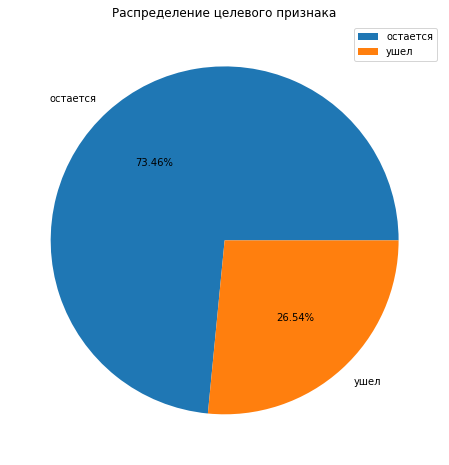

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Распределение целевого признака')
plt.pie(clients['Left'].value_counts(),labels = ['остается', 'ушел'], autopct='%0.2f%%')
plt.legend()
plt.show()

26% клиентов из имеющейся выборки перестали быть абонентами. Есть некоторый дисбаланс классов, с ним с могу бороться с помощью балансировки в моделях (class_weight), либо использовать upsampling обучающей выборки.

### Распределение числовых признаков

В нашем датасете признаков с непрерывными числовыми признаками немного, всего два: сумма ежемесячных трат и общая сумма трат. 

Проверю их на наличие выбросов.

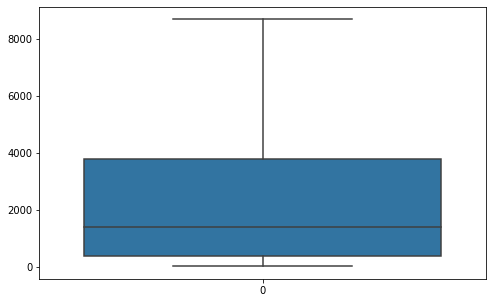

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=clients['TotalCharges'])

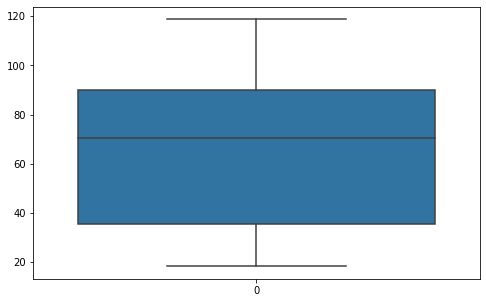

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=clients['MonthlyCharges'])

In [ ]:
clients[['TotalCharges', 'MonthlyCharges']].describe()

,TotalCharges,MonthlyCharges
count,7043.000000,7043.000000
mean,2279.798992,64.761692
std,2266.730170,30.090047
min,18.800000,18.250000
25%,398.550000,35.500000
50%,1394.550000,70.350000
75%,3786.600000,89.850000
max,8684.800000,118.750000


Явных аномалий не наблюдается ни на "ящике с усами", ни на статистическом распределении данных.

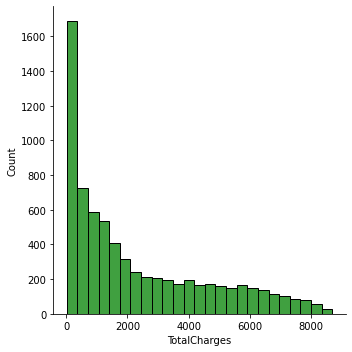

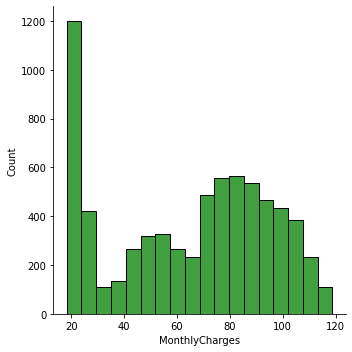

In [ ]:
for i in list(('TotalCharges', 'MonthlyCharges')):
  sns.displot(clients[i], color="green")

У ежемесячных платежей пик на малых значениях, это объясняется самой суммой абоненской платы, 25% абонентов платят не более 35 в месяц. Второй всплеск в районе 80, почти половина всех абонентов платит не менее 70.

Что касается общей суммы платежей клиентов, здесь тоже есть пик на малых значениях, судя по всему это объясняется тем, что эти клиенты недавно стали абонентами компании.

In [ ]:
clients[clients['TotalCharges'] < clients['TotalCharges'].quantile(0.1)]['BeginDate'].value_counts()

2020-01-01    227
2019-12-01    142
2019-11-01    128
2019-10-01    101
2019-09-01     85
2020-02-01     11
2019-08-01      8
2019-07-01      3
Name: BeginDate, dtype: int64

Действительно, основная их часть подключилась за 1-3 месяца до выгрузки данных.

Посмотрю корреляцию численных признаков с целевым.

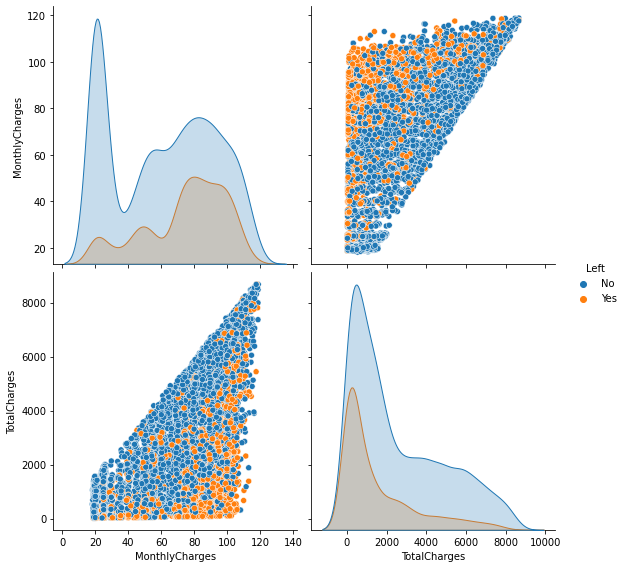

In [ ]:
sns.pairplot(clients, hue='Left',  height=4)

График показывает, что часто уходят клиенты, ежемесячная плата которых выше средней.

Клиенты, у которых еще не так много суммарных расходов, уходят не реже тех, кто потратил много, то есть клиенты не всегда готовы дать компании время завоевать их лояльность.

### Распределение категориальных признаков

Основная часть наших признаков - категориальные, рассмотрю, как они распределяются. Сначала посмотрю на персональные данные клиентов на предмет того, нет ли в нашей выборке значительного сдвига к какой-либо определенной группе. Проверить адекватность признаков с данными об использовании услуги не получится, ведь мы не здесь, какая доля будет "нормальной".

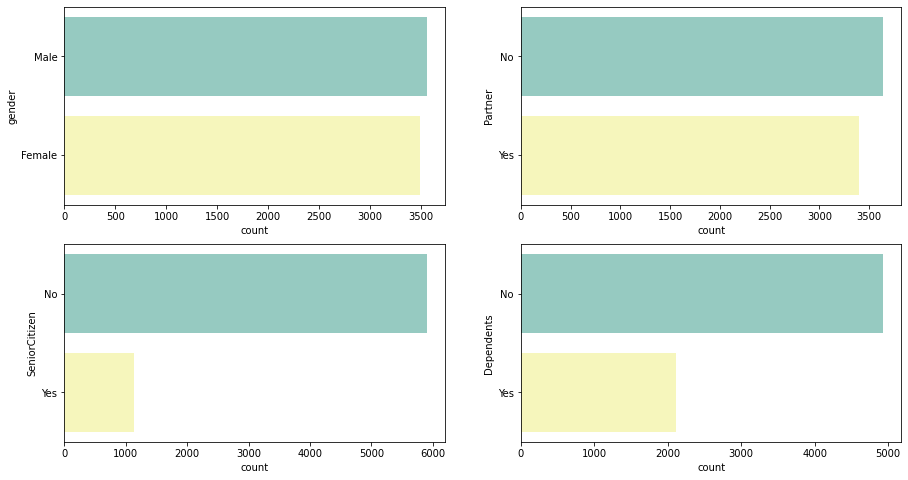

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

sns.countplot(y="gender", data=clients, palette="Set3", ax = ax0[0])
sns.countplot(y="SeniorCitizen", data=clients, palette="Set3", ax = ax1[0])
sns.countplot(y="Partner", data=clients, palette="Set3", ax=ax0[1])
sns.countplot(y="Dependents", data=clients, palette="Set3", ax=ax1[1])

Персональные данные показывают, что выборка репрезентативна, соотношения адекватные.

Также рассмотрю категориальные признаки, относящиеся к платежам:

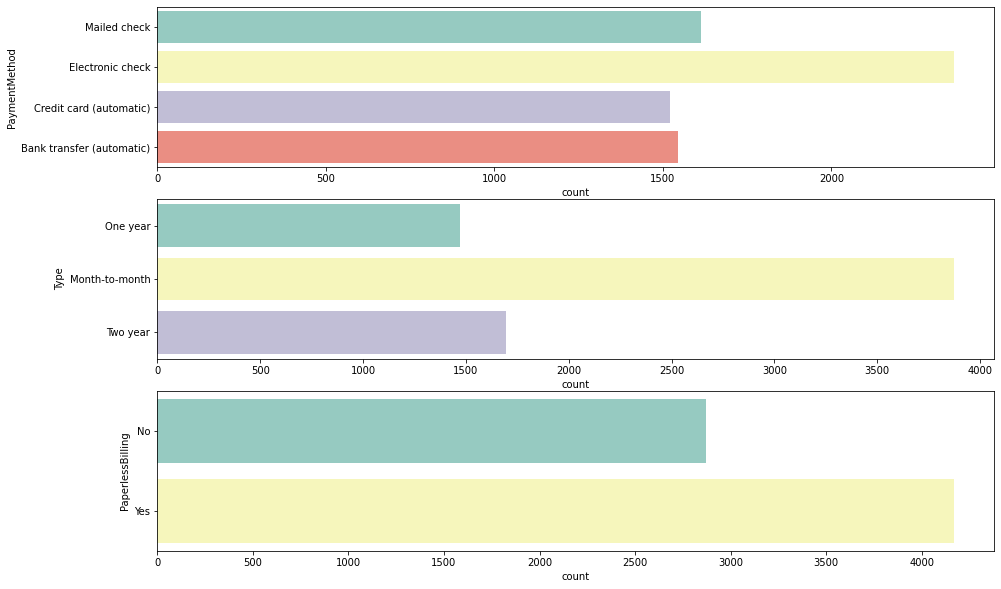

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))

sns.countplot(y="PaymentMethod", data=clients, palette="Set3", ax=ax0)
sns.countplot(y="Type", data=clients, palette="Set3", ax = ax1)
sns.countplot(y="PaperlessBilling", data=clients, palette="Set3", ax=ax2)

Электронный чек как тип оплаты несколько опережает другие виды платежей, которые в свою очередь одинаково популярны среди клиентов.

Клиентов, предпочитающих безналичных платеж несколько больше, чем платящих наличными.

Среди типов регулрности платежей около 50% клиентов выбирают ежемесячный платеж, сразу за год и за два года платят примерно одинаковое количество пользователей.

Теперь перейду к основному интересующему нас показателю: распределение по признакам в отношении целевого признака. Посмотрим на портрет уходящего клиента, и на клиента, остающегося лояльным.

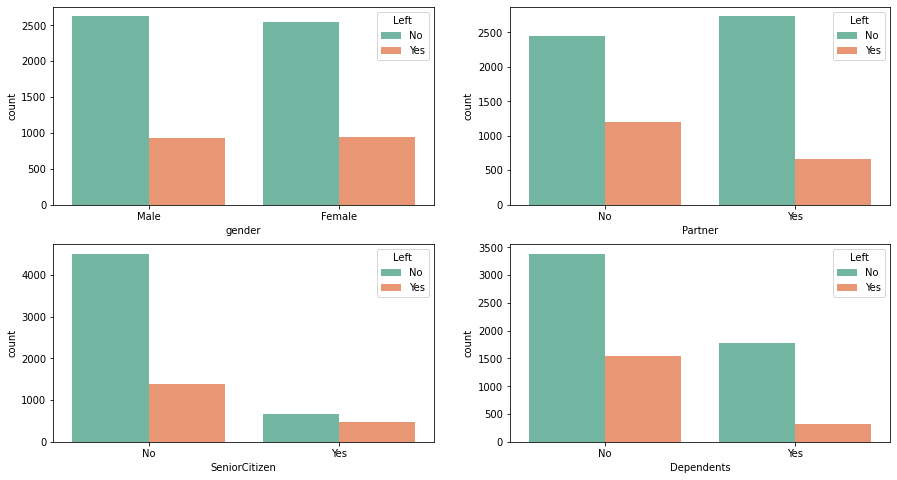

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=2,
                                    figsize=(15, 8))
sns.countplot(x="gender", hue="Left", data=clients, palette="Set2", ax = ax0[0])
sns.countplot(x="SeniorCitizen", hue="Left", data=clients, palette="Set2", ax = ax1[0])
sns.countplot(x="Partner", hue="Left", data=clients, palette="Set2", ax = ax0[1])
sns.countplot(x="Dependents", hue="Left", data=clients, palette="Set2", ax=ax1[1])

На основе графиков по персональным данным могу выделить, что клиенты, имеющие партнеров и иждивенца менее активно уходят, они сохраняют лояльность телеком-компании. Те,кто не имеет партнера и иждивенцев чаще готовы поменять оператора.

Также интересно отметить, то пенсионеры аткивно уходят, процент оттока намного выше, чем у более молодых людей. Возможно это связано не только с желанием сменить оператора.

In [ ]:
clients.query('SeniorCitizen == "Yes" and Left == "Yes"')['EndDate'].value_counts()

2020-01-01    126
2019-12-01    120
2019-10-01    118
2019-11-01    112
Name: EndDate, dtype: int64

И отток пенсионеров тоже равномерный.

Теперь рассмотрю отток по категориям, связанным с оплатой:

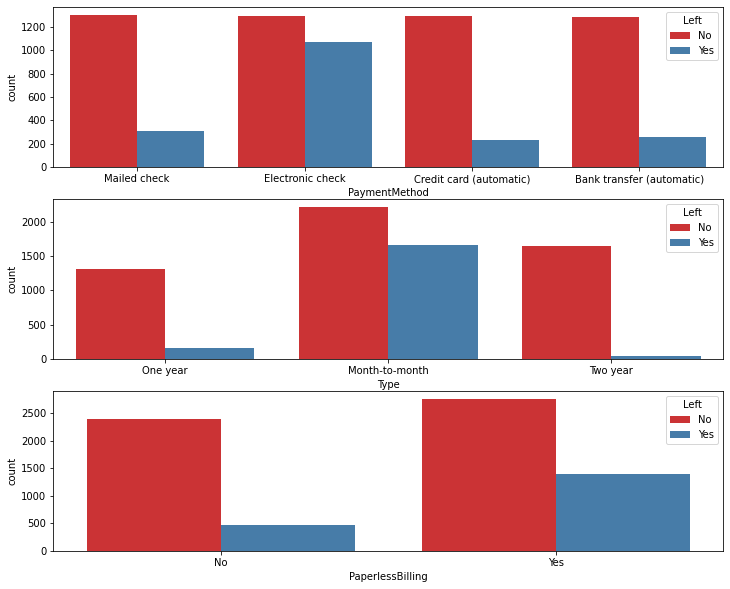

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

sns.countplot(x="PaymentMethod", hue="Left", data=clients, palette="Set1", ax=ax0)
sns.countplot(x="Type", hue="Left", data=clients, palette="Set1", ax = ax1)
sns.countplot(x="PaperlessBilling", hue="Left", data=clients, palette="Set1", ax=ax2)

Бо́льшая доля уходящих среди тех, кто платит безналично. Также отметим, что клиенты с ежемесячным платежем гораздо чаще уходят чем те, кто платит за год или два сразу. Возможно они менее консервативны, а также не ждут, пока закончится оплаченный период услуг.

Сразу заметно, как много клиентов, предпочитающих платить электронным чеком, уходит, число стремится к 50 %. Проверю, может для них был резкий отток, связанный именно с этим видом платежа:

In [ ]:
clients.query('PaymentMethod == "Electronic check" and Left == "Yes"')['EndDate'].value_counts()

2020-01-01    280
2019-11-01    265
2019-12-01    265
2019-10-01    261
Name: EndDate, dtype: int64

Нет, уходили равномерно. Поэтому ввиду того, что клиентов с данным типом оплаты в выборке больше всего, телеком-компании необходимо обратить внимание на эту группу в первую очередь.

Смотрим далее, у нас есть пользователи интернета, телефонии и те, кто пользуется обеими услугами, выделю признаки: OnlyInternet, OnlyPhone, InternetAndPhone.

In [ ]:
clients.loc[clients['InternetService'] == 'NoInternet', 'ServiceType'] = 'OnlyPhone'
clients.loc[clients['MultipleLines'] == 'NoPhone', 'ServiceType'] = 'OnlyInternet'
clients['ServiceType'] = clients['ServiceType'].fillna('InternetAndPhone')

Теперь посмотрю на распределение по целевому признаку:

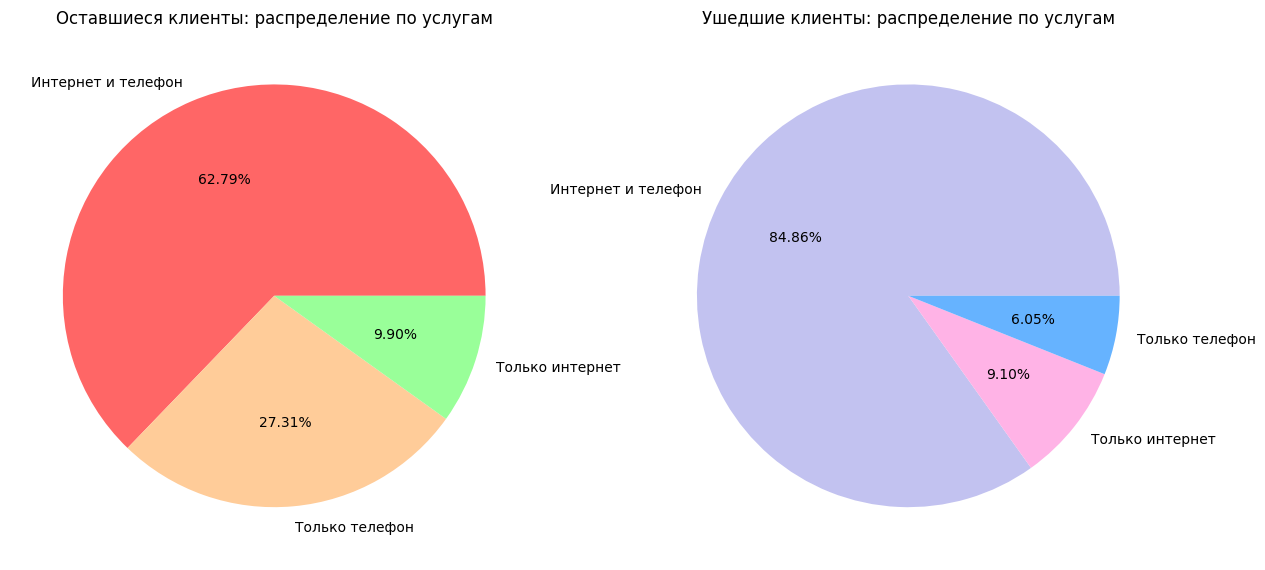

In [ ]:
fig = plt.figure(figsize=(15,8), dpi=100)

ax1 = fig.add_subplot(121)

data = clients[clients['Left'] == 'No']['ServiceType'].value_counts()
plt.title('Оставшиеся клиенты: распределение по услугам')
ax1.pie(data, labels = ['Интернет и телефон', 'Только телефон', 'Только интернет'], autopct='%0.2f%%', 
        colors=['#ff6666', '#ffcc99', '#99ff99', '#66b3ff'])

ax2 = fig.add_subplot(122)

plt.title('Ушедшие клиенты: распределение по услугам')
data = clients[clients['Left'] == 'Yes']['ServiceType'].value_counts()
ax2.pie(data, labels = ['Интернет и телефон', 'Только интернет', 'Только телефон'], autopct='%0.2f%%',
        colors=['#c2c2f0','#ffb3e6', '#66b3ff'])

plt.show()

Сильно заметно, что лояльные клиенты чаще пользуются только телефоном, чем ушедшие. Среди ушедших, наоборот, большее количество интернет-юзеров. Вероятно, в первую очередь надо работать с аудиторией, активно использующую услуги интернета.

Расмотрю дополнительные услуги:

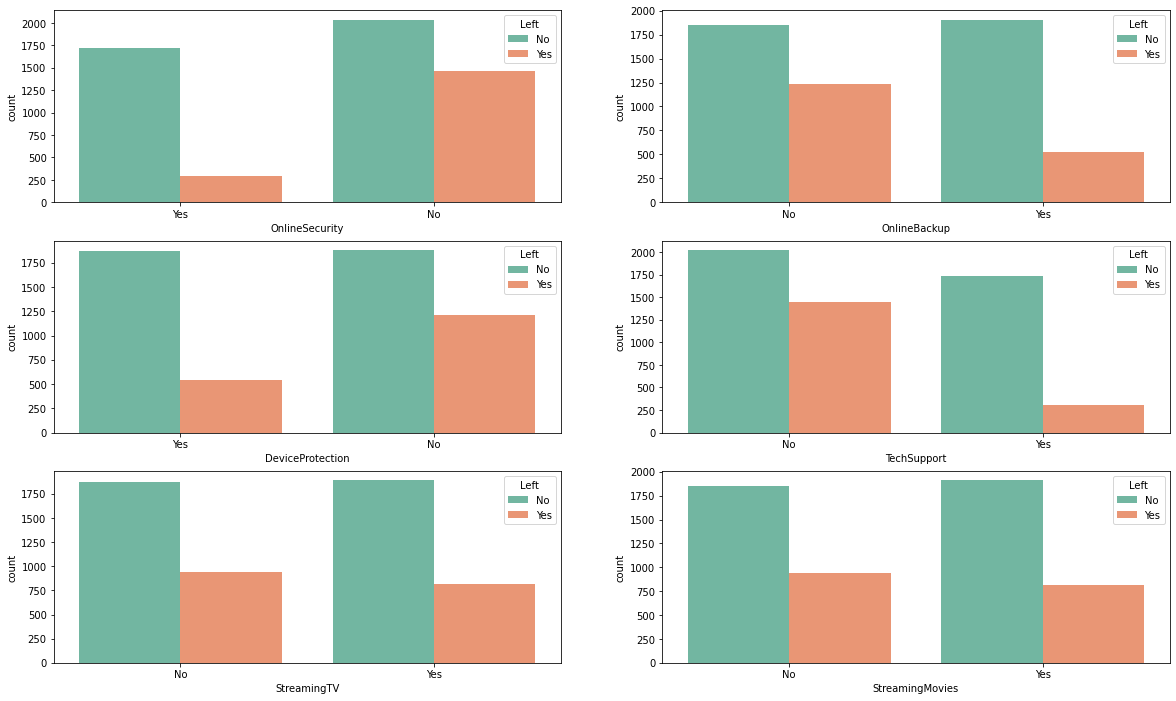

In [ ]:
# предварительно выберу именно тех клиентов, кто пользуется интернетом
int_clients = clients.query('ServiceType == "InternetAndPhone" or ServiceType == "OnlyInternet"')
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=2,
                                    figsize=(20, 12))
sns.countplot(x="OnlineSecurity", hue="Left", data=int_clients, palette="Set2", ax = ax0[0])
sns.countplot(x="OnlineBackup", hue="Left", data=int_clients, palette="Set2", ax = ax0[1])
sns.countplot(x="DeviceProtection", hue="Left", data=int_clients, palette="Set2", ax = ax1[0])
sns.countplot(x="TechSupport", hue="Left", data=int_clients, palette="Set2", ax=ax1[1])
sns.countplot(x="StreamingTV", hue="Left", data=int_clients, palette="Set2", ax = ax2[0])
sns.countplot(x="StreamingMovies", hue="Left", data=int_clients, palette="Set2", ax=ax2[1])

Среди клиентов стриминговых сервисов количество ушедших соответствует распределению ушедших в целом по датасету.

А что касается пользователей остальных интернет-услуг, здесь заметна лояльность тех, кто пользуется ими, процент ушедших среди клиентов без данных подключенных услуг резко возрастает. Это может говорить о том, что данные сервисы могут действоватьв качестве удерживающего фактора.

Также посмотрю на распределение ушедших клиентов по типу подлючения интернета и наличию возможности ведения параллельных линий:

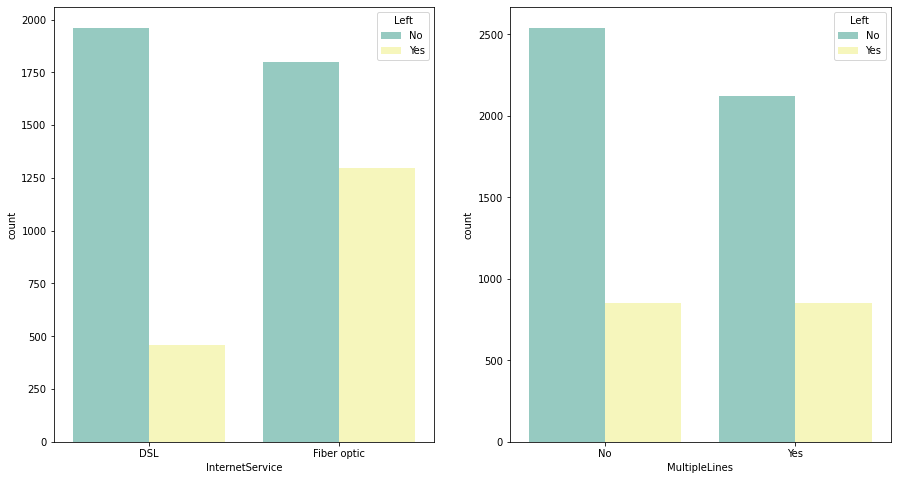

In [ ]:
#выделю тех, кто пользуется телефоном:
phone_clients = clients.query('ServiceType == "InternetAndPhone" or ServiceType == "OnlyPhone"')
fig, ax0 = plt.subplots(nrows=1, ncols=2,
                            figsize=(15, 8))
sns.countplot(x="InternetService", hue="Left", data=int_clients, palette="Set3", ax = ax0[0])
sns.countplot(x="MultipleLines", hue="Left", data=phone_clients, palette="Set3", ax = ax0[1])

Наличие многоканальности телефонии практически не влияет на уход, а вот среди клиентом с оптоволоконным кабелем больший процент оттока, чем у клиентов DSL. Это также может быть связано с консерватизмом, но все же нужно обратить внимание на качество предоставления услуг с оптоволоконным кабелем.

Таким образом на основе исследовательского данного мы убедились в следующем: 

1. Выборка сама по себе достаточно репрезентативна.
2. Есть некоторый дисбаланс классов: 26% клиентов в выборке ушло. Буду использовать 'class_weight' в моделях, либо проведу upsampling.
3. Выбросов в данных о суммах платежей нет, прослеживается разделение на две группы по тратам, клиенты с большими ежемесячными платежами уходят чаще.
4. Консервативная группа (наличные платежи, платят сразу за год или два, выбирают телефонию, DSL) более лояльны и уходят реже.
5. Подключенные нтернет-услуги способствуют удержанию клиентов.

## Подготовка данных для обучения моделей

Перед обучением моделей нужно посмотреть корреляцию признаков, создать новые признаки, разделить на выборки. Начну с создания признаков.

### Создание признаков

Для улучшения качества модели создам новые признаки в данных.

На этапе EDA для анализа я поделил клиентов на 3 группы: тех, кто пользуется только телефоном, тех, кто пользуется только интернетом и тех, кто пользуется обеими услугами. Оставлю этот новый признак для обучения модели.

Добавлю новый признак - длительность с месяца заключения договора до месяца выгрузки. Наша задача - недопустить утечки целевого признака, поэтому помимо удаления EndDate, я удалю BeginDate. Также нельзя использовать косвенные признаки, например, месяц от EndDate и тд. Но я добавлю длительность не от начала до конца контракта, а от начала до даты выгрузки. С одной стороны, чем дольше длительность договора, тем больше шанс, что клиент с нами, но с другой стороны, он мог уйти и в месяц выгрузки данных - это один из четырех месяцев, когда происходил отток клиентов.

In [ ]:
clients['MonthesFromBegin'] = (pd.Timestamp('2020-02-01') - clients['BeginDate']).astype('timedelta64[M]').astype('int')

### Удаление ненужных признаков

Чтобы не допустить утечку целевого признака, удалю EndDate, а также BeginDate.

In [ ]:
clients = clients.drop(['EndDate', 'BeginDate'], axis=1)

Также заменю в целевом признаке "Yes" и "No" на 0 и 1.

In [ ]:
clients['Left'] = clients['Left'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
clients

,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Left,gender,SeniorCitizen,Partner,Dependents,ServiceType,MonthesFromBegin
customerID,,,,,,,,,,,,,,,,,,,,
5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,Male,No,No,No,InternetAndPhone,34
3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,No,No,No,InternetAndPhone,4
9237-HQITU,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,No,No,No,InternetAndPhone,5
9305-CDSKC,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1,Female,No,No,No,InternetAndPhone,11
1452-KIOVK,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,Male,No,No,Yes,InternetAndPhone,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4501-VCPFK,NoPhone,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Electronic check,35.75,1022.50,0,Male,No,No,No,OnlyInternet,26
2274-XUATA,NoPhone,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),63.10,4685.55,0,Male,Yes,Yes,No,OnlyInternet,71
2235-DWLJU,NoPhone,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.40,263.05,0,Female,Yes,No,No,OnlyInternet,6


### Мультиколлинеарность

Проверю корреляцию признаков в датасете, восопльзуюсь библиотекой phik. 

Сначала построю таблицу с корреляцией признаков, затем таблицу с статистической значимостью.

In [ ]:
phik_overview = clients.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Left', 'MonthesFromBegin']


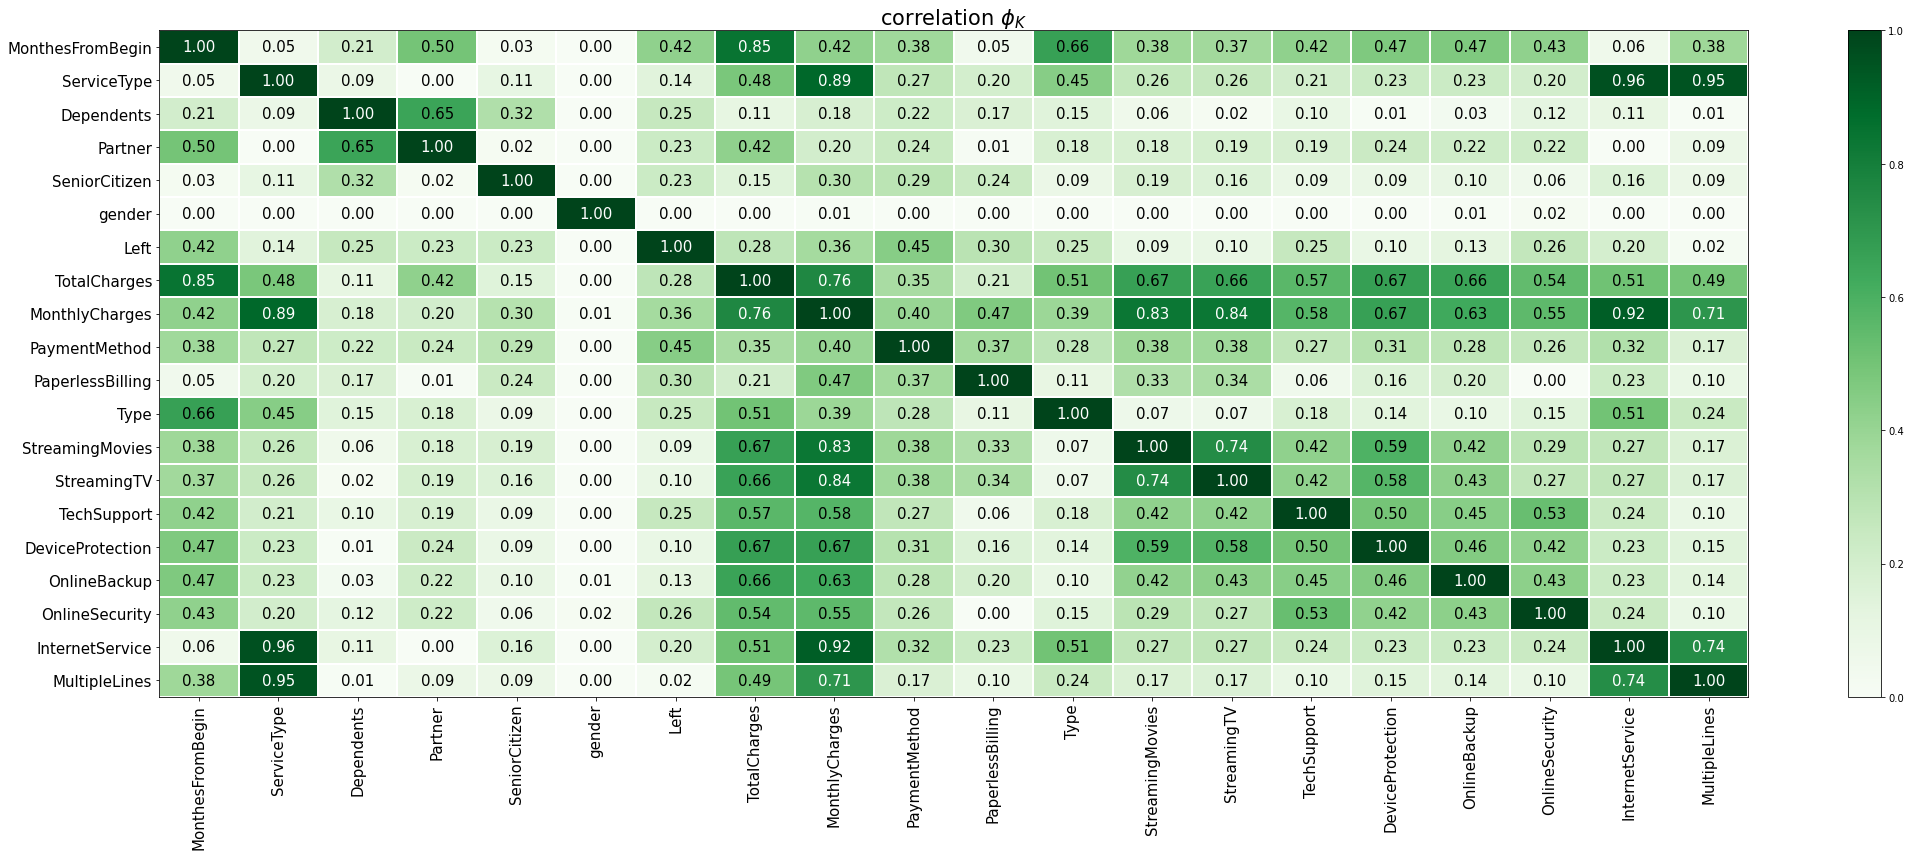

In [ ]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(30, 12))
plt.tight_layout()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Left', 'MonthesFromBegin']


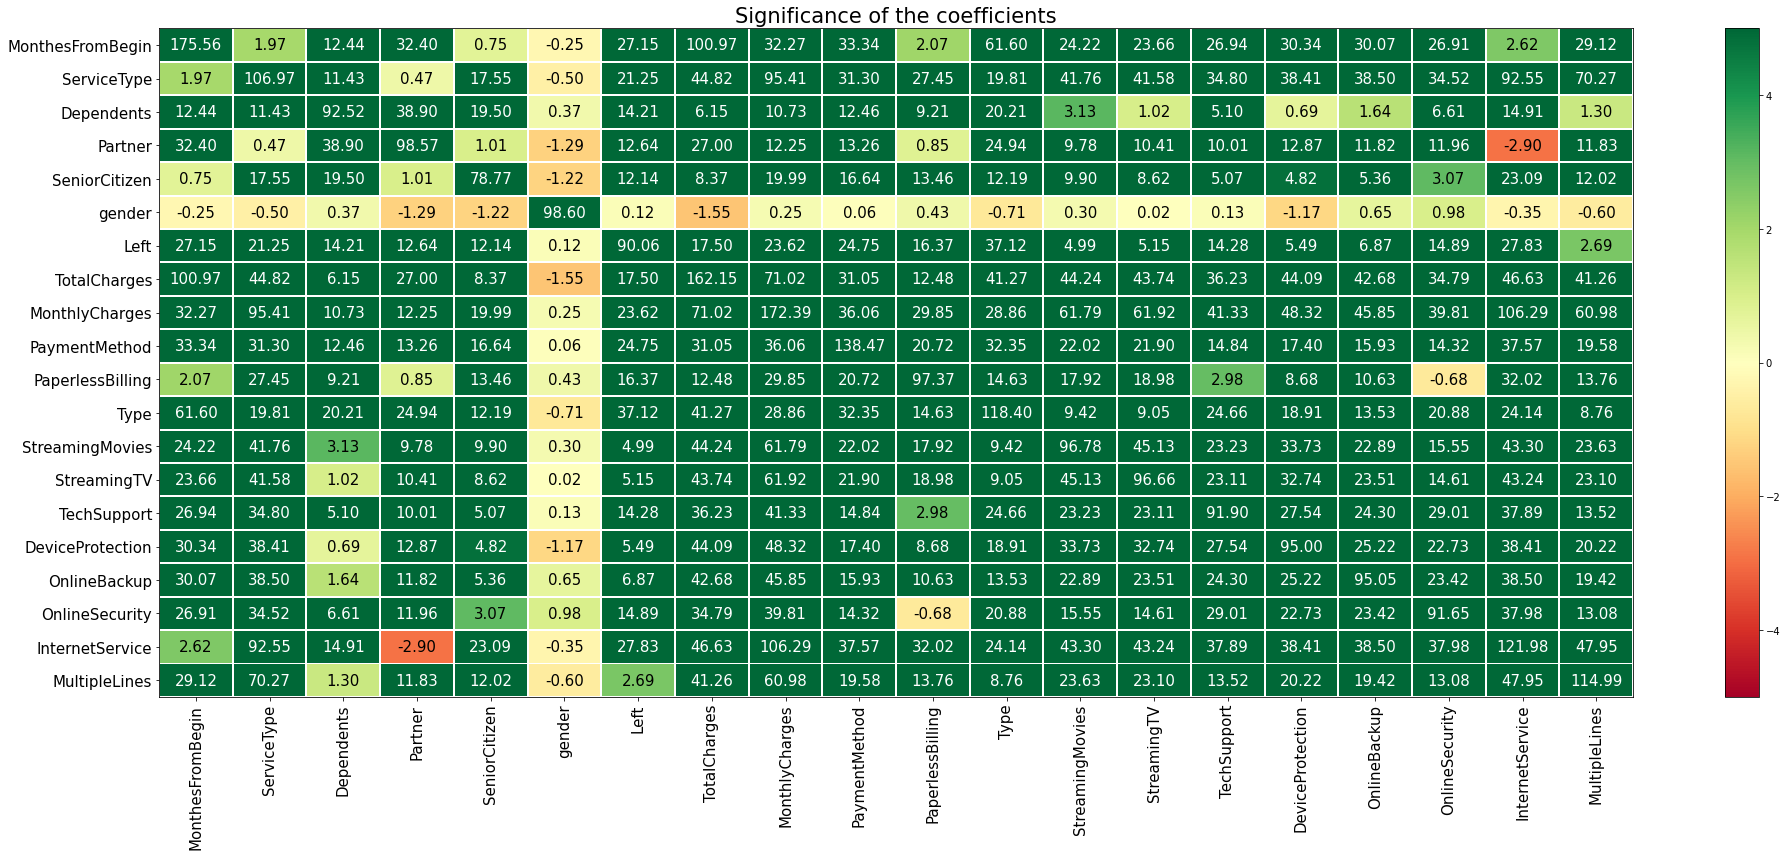

In [ ]:
significance_overview = clients.significance_matrix()
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(28, 12))
plt.tight_layout()

Можно отметить большую корреляцию между ServiceType и признаками с видами услуг, но я сам ее выделил для обучения модели. Пол клиента не коррелирует с  целевым признаком и имеет малую статистическую значимость коэффициента корреляции. Стоимость в месяц сильно коррелирует с типом интернет подключения, но удалять один из признаков считаю нецелесообразным.

### OHE

Не все категориальные признаки датасета являются бинарными, выполню для них One-Hot Encoding.

Я буду использовать модели градиентного бустинга, для которых это не понадобится, но также и более простые модели, где OHE нужен, поэтому буду использовать отдельную переменную.

In [ ]:
clients_ohe = pd.get_dummies(clients, drop_first=True)

### Разделение на выборки

Подготовлю выборки к обучению: разделю на тренировочную и тестовую.

In [ ]:
# для градиентного бустинга
target = clients['Left']
features = clients.drop('Left', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=290822)

In [ ]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((5634, 19), (1409, 19), (5634,), (1409,))

In [ ]:
# c OHE
target_ohe = clients_ohe['Left']
features_ohe = clients_ohe.drop('Left', axis=1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.20, random_state=290822)

In [ ]:
features_train_ohe.shape, features_test_ohe.shape, target_train_ohe.shape, target_test_ohe.shape

((5634, 25), (1409, 25), (5634,), (1409,))

### Стандартизация

Также для более простых моделей проведу стандартизацию численных признаков:

In [ ]:
numeric = ['MonthlyCharges', 'TotalCharges', 'MonthesFromBegin']
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

### Upsampling для борьбы с дисбалансом

На этапе EDA было определенно, что в имеющейся выборке есть небольшой дисбаланс классов, сейчас нулей 73%. Решу эту проблему с помощью увеличения тренировочной выборки. Создам отдельную переменную для датасета с upsampling.

In [ ]:
# создам функцию upsample для градиентного бустинга
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled)
    return features_upsampled, target_upsampled

In [ ]:
# для градиентного бустинга
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 3)

In [ ]:
# для простых моделей использую SMOTE
smote = SMOTE()
features_train_ohe_upsampled, target_train_ohe_upsampled = smote.fit_resample(features_train_ohe, target_train_ohe)

In [ ]:
features_train_upsampled.shape, target_train_upsampled.shape, features_train_ohe_upsampled.shape, target_train_ohe_upsampled.shape

((8608, 19), (8608,), (8294, 25), (8294,))

In [ ]:
target_train_upsampled.value_counts()

1    4461
0    4147
Name: Left, dtype: int64

Теперь есть баланс классов, попробую сравнить метрики с использованием upsample и без.

## Обучение моделей

### Dummy модель

В качестве baseline буду использовать dummy модель.

In [ ]:
dummy_model = DummyClassifier()
dummy_model.fit(features_train_upsampled, target_train_upsampled)

DummyClassifier()

In [ ]:
predict_dummy = dummy_model.predict_proba(features_test)[:, 1]
print('ROC-AUC Dummy модели: ' ,roc_auc_score(target_test, predict_dummy))

ROC-AUC Dummy модели:  0.5


Ожидаемо модель не обладает качеством.

### Случайный лес

Как более простую модель буду использовать модель случайный лес. Обучу модель на подготовленных данных. Также сделаю перебор гиперпарметров. Кроссвалидацию проведу на трех фолдах. Также проверю модель при использовании параметра для баланса выборок: class_weight='balanced'.

In [ ]:
params_randomforest = {'n_estimators' : range(100, 160, 10), 'min_samples_split': range(2, 7, 2), 'max_depth': range(2, 7, 2), 'min_samples_leaf': range(2, 7, 2), 'class_weight': ['balanced', None]}

In [ ]:
%%time
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=290822), param_distributions=params_randomforest, cv=3, random_state=290822, scoring='roc_auc', n_jobs=-1)
random_search.fit(features_train_ohe, target_train_ohe)

CPU times: user 968 ms, sys: 39.6 ms, total: 1.01 s
Wall time: 10.1 s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=290822),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': range(2, 7, 2),
                                        'min_samples_leaf': range(2, 7, 2),
                                        'min_samples_split': range(2, 7, 2),
                                        'n_estimators': range(100, 160, 10)},
                   random_state=290822, scoring='roc_auc')

In [ ]:
print('Лучше параметры модели: ', random_search.best_params_)
print('Лучшая метрика ROC_AUC: ', random_search.best_score_)

Лучше параметры модели:  {'n_estimators': 130, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 6, 'class_weight': None}
Лучшая метрика ROC_AUC:  0.8608641645936014


In [ ]:
print('Оценки после кроссвалидации для различных наборов параметров', random_search.cv_results_['mean_test_score'])

Оценки после кроссвалидации для различных наборов параметров [0.83089979 0.83218444 0.83274318 0.86086416 0.84958037 0.8331371
 0.85994355 0.84811448 0.86062981 0.8325205 ]


'class_weight' предлагается не использовать.

Метрика после подбора равняется 0.86. 

Проверю, как будет работать на обучающем датасете с upsample.

In [ ]:
%%time
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=290822), param_distributions=params_randomforest, cv=3, random_state=290822, scoring='roc_auc', n_jobs=-1)
random_search.fit(features_train_ohe_upsampled, target_train_ohe_upsampled)

CPU times: user 1.27 s, sys: 37.2 ms, total: 1.31 s
Wall time: 12.1 s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=290822),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': range(2, 7, 2),
                                        'min_samples_leaf': range(2, 7, 2),
                                        'min_samples_split': range(2, 7, 2),
                                        'n_estimators': range(100, 160, 10)},
                   random_state=290822, scoring='roc_auc')

In [ ]:
print('Лучше параметры модели: ', random_search.best_params_)
print('Лучшая метрика ROC_AUC: ', random_search.best_score_)

Лучше параметры модели:  {'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 6, 'class_weight': 'balanced'}
Лучшая метрика ROC_AUC:  0.8817577734479833


In [ ]:
print('Оценки после кроссвалидации для различных наборов параметров', random_search.cv_results_['mean_test_score'])

Оценки после кроссвалидации для различных наборов параметров [0.84785028 0.84667735 0.84771924 0.88151703 0.86430751 0.84805151
 0.88066447 0.86510895 0.88175777 0.84762971]


C upsample модель обучилась лучше, теперь обучу модель на лучших гиперпараметрах и с увеличенной выборкой:

In [ ]:
%%time
model_randomforest = RandomForestClassifier(random_state=290822, n_estimators=130, min_samples_split=4, max_depth=6, min_samples_leaf=2)
model_randomforest.fit(features_train_ohe_upsampled, target_train_ohe_upsampled)

CPU times: user 775 ms, sys: 2.41 ms, total: 777 ms
Wall time: 787 ms


RandomForestClassifier(max_depth=6, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=130, random_state=290822)

Проверку на тестовой выборке пока не буду проводить, потому что CatBoost возможно покажет лучший результат на валидации.

### Catboost

Для CatBoost буду использовать данные без OHE, но отдельно выделю категориальные признаки. Переберу гиперпараметры, буду использовать 3 фолда для кроссвалидации.

Проверю с балансировкой auto_class_weights='Balanced', будет ли лучше обучаться модель, чем upsample датасете.

In [ ]:
cat_features = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Type', 'PaperlessBilling', 'PaymentMethod', 'gender',
                        'SeniorCitizen', 'Partner', 'Dependents', 'ServiceType']
catboost_train_data = Pool(data=features_train,
                  label=target_train,
                  cat_features=cat_features)

catboost_train_data_upsampled = Pool(data=features_train_upsampled,
                  label=target_train_upsampled,
                  cat_features=cat_features)

In [ ]:
%%time
# с балансировкой классов auto_class_weights='Balanced'
params = {'learning_rate': [0.01, 0.025, 0.05],
           'depth': [4, 6, 8],
          'l2_leaf_reg': [1,2,3]}

catboost_model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC:hints=skip_train~false', early_stopping_rounds=120, auto_class_weights='Balanced') #task_type='GPU'

grid_result = catboost_model.grid_search(params, catboost_train_data, cv=3, plot=True, partition_random_seed=290822, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Выходные данные были обрезаны до нескольких последних строк (5000).
25:	learn: 0.8651090	test: 0.8538627	best: 0.8538627 (25)	total: 456ms	remaining: 17.1s
26:	learn: 0.8651927	test: 0.8543702	best: 0.8543702 (26)	total: 473ms	remaining: 17.1s
27:	learn: 0.8655212	test: 0.8538322	best: 0.8543702 (26)	total: 492ms	remaining: 17.1s
28:	learn: 0.8654153	test: 0.8540420	best: 0.8543702 (26)	total: 506ms	remaining: 16.9s
29:	learn: 0.8665457	test: 0.8545571	best: 0.8545571 (29)	total: 531ms	remaining: 17.2s
30:	learn: 0.8663014	test: 0.8544312	best: 0.8545571 (29)	total: 536ms	remaining: 16.7s
31:	learn: 0.8668066	test: 0.8550685	best: 0.8550685 (31)	total: 548ms	remaining: 16.6s
32:	learn: 0.8680581	test: 0.8563582	best: 0.8563582 (32)	total: 568ms	remaining: 16.6s
33:	learn: 0.8697327	test: 0.8586610	best: 0.8586610 (33)	total: 588ms	remaining: 16.7s
34:	learn: 0.8697963	test: 0.8582565	best: 0.8586610 (33)	total: 607ms	remaining: 16.7s
35:	learn: 0.8713207	test: 0.8581306	best: 0.8586610

In [ ]:
print('Лучшие гиперпараметры для CatBoost с автобалансировкой классов', grid_result['params'])

Лучшие гиперпараметры для CatBoost с автобалансировкой классов {'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.05}


In [ ]:
print('Cредняя оценка AUC на валидации для CatBoost с автобалансом: ', sum(pd.DataFrame(grid_result)['cv_results']['test-AUC-mean']) / len(pd.DataFrame(grid_result)['cv_results']['test-AUC-mean']))

Cредняя оценка AUC на валидации для CatBoost с автобалансом:  0.9098169956709798


In [ ]:
print('Лучшая оценка AUC на валидации для CatBoost с автобалансом: ', max(grid_result['cv_results']['test-AUC-mean']))

Лучшая оценка AUC на валидации для CatBoost с автобалансом:  0.9274834948615486


Теперь проверю метрику при использовании датасета с upsample:

In [ ]:
%%time
# на upsample выборке

catboost_model_upsampled = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', early_stopping_rounds=120) #task_type='GPU'

grid_result_upsampled = catboost_model_upsampled.grid_search(params, catboost_train_data_upsampled, cv=3, plot=True, partition_random_seed=290822, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Выходные данные были обрезаны до нескольких последних строк (5000).
27:	test: 0.8812840	best: 0.8813778 (26)	total: 663ms	remaining: 23s
28:	test: 0.8815513	best: 0.8815513 (28)	total: 688ms	remaining: 23s
29:	test: 0.8816883	best: 0.8816883 (29)	total: 710ms	remaining: 23s
30:	test: 0.8819772	best: 0.8819772 (30)	total: 733ms	remaining: 22.9s
31:	test: 0.8818760	best: 0.8819772 (30)	total: 757ms	remaining: 22.9s
32:	test: 0.8817180	best: 0.8819772 (30)	total: 778ms	remaining: 22.8s
33:	test: 0.8844458	best: 0.8844458 (33)	total: 803ms	remaining: 22.8s
34:	test: 0.8844391	best: 0.8844458 (33)	total: 827ms	remaining: 22.8s
35:	test: 0.8845404	best: 0.8845404 (35)	total: 857ms	remaining: 22.9s
36:	test: 0.8842265	best: 0.8845404 (35)	total: 889ms	remaining: 23.1s
37:	test: 0.8848394	best: 0.8848394 (37)	total: 912ms	remaining: 23.1s
38:	test: 0.8851634	best: 0.8851634 (38)	total: 934ms	remaining: 23s
39:	test: 0.8852383	best: 0.8852383 (39)	total: 955ms	remaining: 22.9s
40:	test: 0.88631

In [ ]:
print('Лучшие гиперпараметры для CatBoost на upsample выборке', grid_result_upsampled['params'])

Лучшие гиперпараметры для CatBoost на upsample выборке {'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.05}


In [ ]:
print('Cредняя оценка AUC на валидации для CatBoost на upsample выборке: ', sum(pd.DataFrame(grid_result_upsampled)['cv_results']['test-AUC-mean']) / len(pd.DataFrame(grid_result_upsampled)['cv_results']['test-AUC-mean']))

Cредняя оценка AUC на валидации для CatBoost на upsample выборке:  0.9658753381455679


In [ ]:
print('Лучшая оценка AUC на валидации для CatBoost на upsample выборке: ', max(grid_result_upsampled['cv_results']['test-AUC-mean']))

Лучшая оценка AUC на валидации для CatBoost на upsample выборке:  0.9885915779946927


CatBoost после подбора гиперпараметров и кроссвалидации показал результат лучше, чем случайный лес, поэтому проверю метрику roc_auc модели на тестовой выборке:

Следует отметить, что в итоге увеличение выборки влияет положительно на нашу метрику. Но метрика ROC-AUC не сильно чувствительна к балансу классов, и при кроссвалидации после апсемплинга всей выборки оценка может быть неправильной из-за некоторой утечки в валидационные блоки. Поэтому главное оценивать качество модели по тестовой выборке.

In [ ]:
predict_test_upsampled = catboost_model_upsampled.predict_proba(features_test)[:, 1]
print('ROC-AUC модели CatBoost на тестовой выборке с upsample выборкой:' ,roc_auc_score(target_test, predict_test_upsampled))

ROC-AUC модели CatBoost на тестовой выборке с upsample выборкой: 0.9282589966200545


In [ ]:
predict_test = catboost_model.predict_proba(features_test)[:, 1]
print('ROC-AUC модели CatBoost на тестовой выборке:' ,roc_auc_score(target_test, predict_test))

ROC-AUC модели CatBoost на тестовой выборке: 0.9357300529677758


Метрика ROC-AUC на тестовой выборке равна **0.935.**

Также оценю accuracy лучшей модели:

In [ ]:
pred_acc = catboost_model.predict(features_test)
print('Accuracy лучшей модели CatBoost на тестовой выборке:' , accuracy_score(target_test, pred_acc))

ROC-AUC модели CatBoost на тестовой выборке: 0.8814762242725337


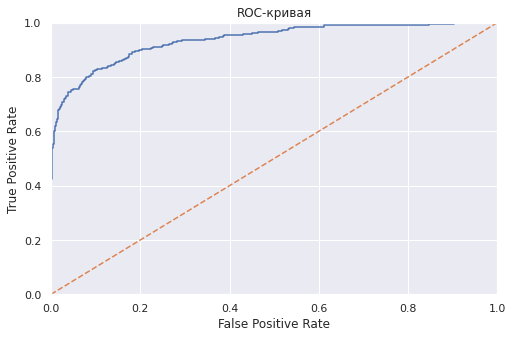

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, predict_test)

sns.set()
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

На графикe ROC-кривой видно, что модели удалось добиться высокого уровня качества.

Также построю матрицу ошибок:

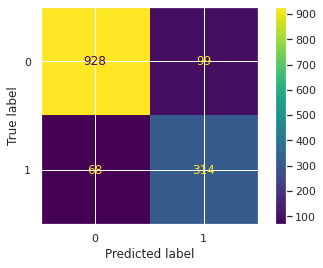

In [ ]:
y_pred = catboost_model.predict(features_test)
cm = confusion_matrix(target_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

Модель показывает хорошую точность, в соотношении двух классов можно сказать, что модель лучше предсказывает тех клиентов, кто действительно остается, и больше ошибается в процентном соотношении, отмечая тех, кто уйдет.

Также посмотрю на график, отражающий значимость признаков для модели

Text(0.5, 1.0, 'Feature Importance')

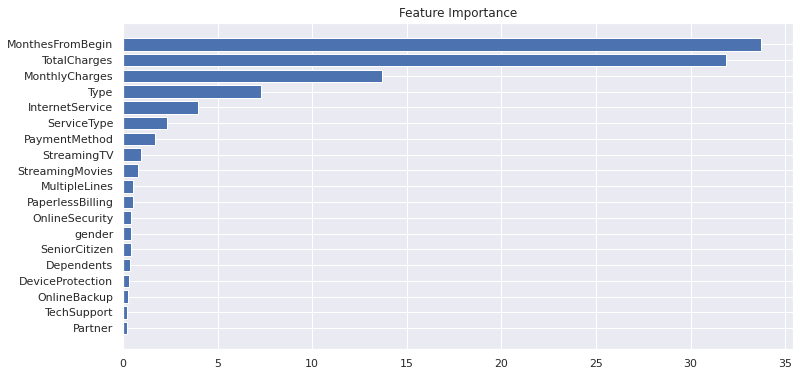

In [ ]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')

Больше всего для модели имеют значения данные о общих расходах клиента и количестве месяцев с начала контракта до даты выгрузки датасетов. Также достаточно сильно важны данные о ежемесячных расходах, периодичности платежа и части услуг. 

## Выводы

Отток клиентов был исследован на предоставленной выборке, были выявлены характерные черты потребительского поведения тех клиентов, которые ушли, и тех, кто остается лояльным компании. 

Были предложены направления в предоставлении услуг, на которые компании нужно обратить внимание в первую очередь, чтобы ослаблять отток клиентов.

С помощью обучения моделей машинного обучения удалось добиться высокого качества предсказания, того какие клиенты могут уйти, это повысит эффективность деятельности компании по удержанию клиентов.

## Отчёт

**"Телеком: прогноз оттока клиентов"**

---

**Задача** исследования состоит в следующем:

От оператора связи поступил запрос на создание модели прогнозирования оттока клиентов для того, чтобы способствовать их удержанию путем предложения промокодов и специальных условий клиентам, намеревающимся уйти.

Исходные данные представляют собой выборку с персональными данными о некоторых клиентах, информацию об их тарифах и договорах, подключенных услугах, также для каждого абонента указана дата его ухода, для тех, кто не ушел, указана дата выгрузки.

Моей **целью** является создание качественной модели (метрика ROC-AUC должны быть больше 0.88) для решения поставленной задачи, также будет полезным предоставить на основе анализа данных некоторые рекомендации для компании по удержанию клиентов. 

После обзора данных и изучения целей проекта автором был составлен **план** **выполнения** поставленной цели, с разделением на отдельные задачи.

На этапе **предобработки** данных после импорта необходимых инструментов и в соответствии с планом были изменены типы данных на соответствующие характеру признаков. Так, например, тип данных в признаке TotalCharges был изменен с текстового на числовой (из object в float64). После такой операции оказалось, что в столбце появились пропуски, после рассмотрения и анализа оказалось, что им соответствуют строки с активными пользователями, которые подключились в дату, когда была выгружены данные, т.е 1 февраля 2020. Автор убрал пропуски путем замены общих расходов на их расходы в месяце, таким образом в TotalCharges для таких клиентов появились суммы расходов в месяц подключения из MonthlyCharges.

Дубликатов в данных не оказалось. Категориальные признаки с "Yes" и 'No" было принято решение не преобразовывать для удобства работы с ними при дальнейшем анализе, они понадобились на этапе EDA для большей интерпретируемости в графиках. Исходные датафреймы personal, contract, internet и phone были преобразованы в одну таблицу clients, объединение происходило по общему признаку customer_id, в новой таблице не имеющие значения для характеристики пользователя id-номера были преобразованы в индексы. 

После объединения таблиц также появлились пропуски, это связано с тем, что не все пользуются всем спектром услуг телеком-компании. Автор решил для большей информативности данных выделить отдельные категории по услугам в отдельный признак: для тех, кто не пользуется интернетом пропуски в InternetService были заменены на "NoInternet", а в MultipleLines для тех, кто не пользуется телефоном - на "NoPhone". Пропуски в дополнительных услугах тех, кто не пользуется интернетом, были заменены на "No".

Согласно плану далее был проведен **исследовательский анализ данных**. В его рамках было установлено, что явных аномалий в данных нет. Автор сначала исследовал все признаки на адекватность представления в выборке - данные оказались репрезентативны. Было решено изучить все признаки, построены несколько графиков распределения признаков, выявлены услуги, пользователи которых более склонны к уходу или, наоборот, более лояльны. 

На персональные данные компания вряд-ли может повлиять. Например, в ходе анализа было установлено, что клиенты, имеющие партнеров и иждивенца менее активно уходят и сохраняют лояльность провайдеру. Пенсионеры аткивно уходят, процент оттока намного выше, чем у молодых, но без дополнительных данных нельзя точно сказать, что это связано только с желанием сменить телеком-оператора.

Другие признаки могут стать объектом более пристального внимания компании. Автор предложил компании несколько **рекомендаций**, которые могут повлиять на лояльность клиентов:
1. Клиенты с ежемесячным платежем гораздо чаще уходят, чем те, кто платит ежегодно или раз в 2 года. Стоит рассмотреть варианты альтернативной периодичности платежей для клиентов.
2. Среди типов оплаты сильно выделяется по проценту уходящих клиентов оплата электронным чеком. Нужно рассмотреть, возможно именно неудобство в реализации данного платежного инструмента становится важной причиной для оттока.
3. Лояльные клиенты чаще пользуются только телефоном, чем ушедшие. Среди ушедших, наоборот, большее количество интернет-юзеров. Вероятно, в первую очередь телеком-компании для удержания клиентов надо сделать акцент на улучшение процессов работы с аудиторией, активно использующей услуги интернета.
4. Подключенные дополнительные интернет-услуги положительно влияют на лояльность клиентов, возможно стоит более активно предлагать их другим пользователям.
5. Среди клиентом с оптоволоконным кабелем больший процент оттока, чем у клиентов DSL. Это может быть связано с консерватизмом, но все же стоит обратить внимание на качество предоставления услуг с оптоволоконным кабелем.

Далее была проведена **подготовка признаков для обучения**. Для улучшения модели были введены новые признаки: группы по пользованию клиентами услугами (только телефон, только интернет или обе услуги), а также месяца с начала действия договора клиента до даты выгрузки данных. Такой числовой признак был сформирован для того, чтобы не допустить утечки целевого признака: просто продолжительность договора каждого клиента могла привести к переобучению моделей.

Числовые признаки с датой начала и окончания договора были соответственно удалены. Итоговый список признаков, использующихся в обучении являлся следующим:


In [ ]:
features.columns

Index(['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'ServiceType', 'MonthesFromBegin'],
      dtype='object')

График мультиколлинеарности показал сильную корреляцию между некоторыми признаками, но не с целевым, другие признаки автор не удалял.

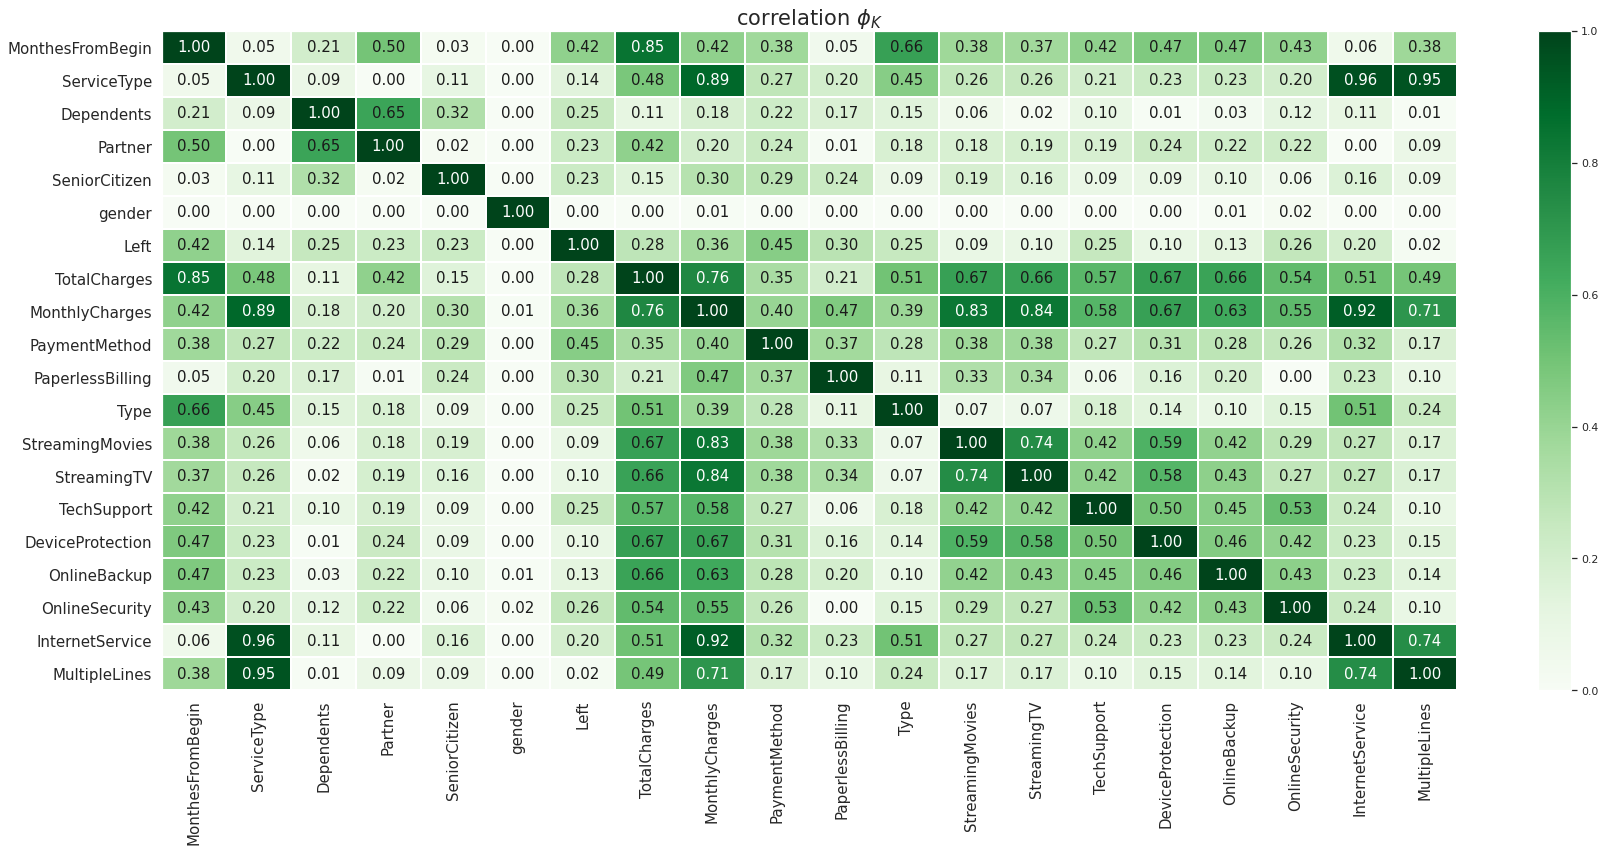

In [ ]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(25, 12))
plt.tight_layout()

Автор решил использовать более простую и более сложную модели, потому что если результат случайного леса будет не хуже результата CatBoost, не было бы смысла использовать более долгую в обучении и ресурсозатратную модель. Для случайного леса была проведена стандартизация и One-Hot Encoding признаков, также upsample выборки с помощью SMOTE.

В начале **этапа обучения моделей** автор на всякий случай проверил, как работает на имеющихся данных dummy модель: она ожидаемо не показала результата (ROC-AUC = 0.5). Далее была обучена модель случайного леса, после перебора гиперпараметров были найдены оптимальные: n_estimators': 130, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 6. Метрика ROC-AUC на кроссвалидации равняется 0.86.

Метрика неплохая, но далее был CatBoost, перебор гиперпараметров определил оптимальными следующие: depth: 4, l2_leaf_reg: 1, learning_rate: 0.05. Средняя оценка на кроссвалидации 0.90, поэтому проверка на тестовой выборке проходила для CatBoost - итоговая метрика ROC-AUC = 0.935.

Метрика итоговой модели достаточно высока, матрица ошибок показала, что модель лучше предсказывает тех клиентов, кто действительно остается, и немного хуже работает в процентном соотношении, отмечая тех, кто уйдет.

Ниже приведена таблица с данными моделей:

In [ ]:
df = {'Модель': ['CatBoostClassifier', 'Случайный лес'], 
      'ROC-AUC на кроссвалидации': [0.927, 0.861],
      'ROC-AUC на тесте': [0.935, 'N/A'],
      'Accuracy на тесте': [0.88, 'N/A'],
      'Лучшие гиперпараметры': ["depth: 4, l2_leaf_reg: 1, learning_rate: 0.05", "n_estimators: 130, min_samples_split: 4, min_samples_leaf: 2, max_depth: 6"]}

pd.set_option('display.max_colwidth', None)
pd.DataFrame(df).set_index('Модель')

,ROC-AUC на кроссвалидации,ROC-AUC на тесте,Accuracy на тесте,Лучшие гиперпараметры
Модель,,,,
CatBoostClassifier,0.927,0.935,0.88,"depth: 4, l2_leaf_reg: 1, learning_rate: 0.05"
Случайный лес,0.861,N/A,N/A,"n_estimators: 130, min_samples_split: 4, min_samples_leaf: 2, max_depth: 6"


Среди признаков датасета самыми важными для модели стали данные о общих расходах клиента и количестве месяцев с начала контракта до даты выгрузки датасетов. Также достаточно сильно важны оказались данные о ежемесячных расходах, периодичности платежа и части из услуг.

Text(0.5, 1.0, 'Feature Importance')

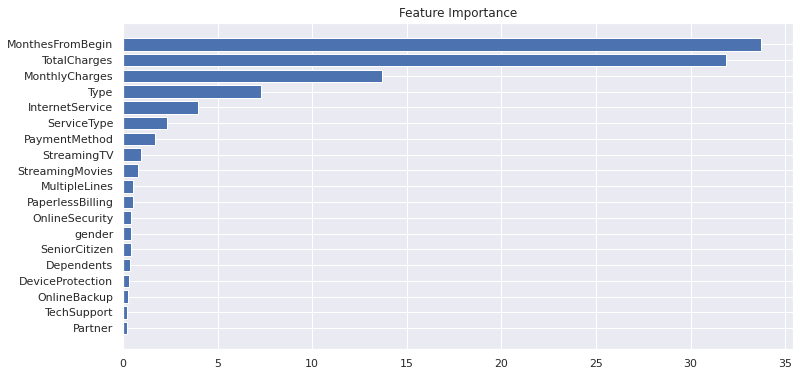

In [ ]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')



Среди возникших трудностей в процессе работы можно выделить следующие:
- В целевом признаке оказался дисбаланс классов - лишь 26% из представленных в выборке клиентов ушли. Не сразу было понятно, как оценить такой дисбаланс и как действовать, но проблема была решена далее путем увеличения выборки для модели случайного леса, для модели градиентного бустинга решением стало использование автобалансировки классов. Следует отметить, что на ROC_AUC модели на тесте это практически не повлияло.
- Проблемой также оказалось, что целевой признак "EndDate" (ушел клиент или нет) был в неподходящем формате, для исследовательского анализа мне нужно было сохранить данный признак и перевести в формат даты, в итоге проблема была решена путем выделения и преобразования в отдельный бинарный признак 'Left', содержащий "No" и "Yes".

**Итогом исследования** стало обучение качественной модели предсказания оттока клиентов, которая отвечает требованиям телеком-компании для способствования решению проблемы удержания абонентов. Дополнительно в результате анализа данных были предложены рекомендации, которые могут положительно повлиять на решения проблемы компании.